# Predicting West Nile Virus in Chicago
## Cleaning, feature engineering, and EDA


* [1 Introduction and Imports](#intro)
* [2. Cleaning](#cleaning)
    *  [2.1 Weather](#weather_c)
        * [2.1.1 Correcting Data Types](#w_missing)
        * [2.1.2 Snow fall](#snow_fall)
        * [2.1.3 Depth](#depth)
        * [2.1.4 Water1](#water1)
        * [2.1.5 Preciptotal](#precip)
        * [2.1.6 Heat and Cool(#w_miss)
        * [2.1.7 Filling missing numerical data](#w_miss)
        * [2.1.8 weather codes](#codesum)
        * [2.1.9 two weather stations](#two_w)
    * [2.2 Mosquito and Spray data](#mosquito_and_spray) 
        * [2.2.1 Spray data](#spray)
        * [2.2.2 Traps](#trap)
        * [2.2.3 uniting the two](#ms)  
* [2.3 EDA and Feature Engineering](#EDA)
    * [2.3.1 Distributions and Pairplots](#dist) 
    * [2.3.2 Species](#species)
    * [2.3.3 WNV comparisons](#grouped)
    * [2.3.4 Lagged Variables](#lagged)
    * [2.3.5 Information Value](#inf_val)
    * [2.3.6 Variance Inflation Factor](#var_in)

## Introduction

According to the CDC, West Nile Virus (WNV) is the leading cause of mosquito-borne disease in the US. The Chicago area reported 6 cases of WNV in the summer of 2020. Although this figure is small, the disease is dangerous, proving fatal for around 1 in 150 people who become infected. Mosquitos, beyond being a nuisance, are a public health concern, and it’s important for densely populated urban areas to control the mosquito population. 

The primary method of mosquito control is to spray insecticide over large areas of land. Along with environmental costs, there are significant costs and inconveniences associated with controlling mosquito populations. The city of Chicago Department of Public Health treats 40,000 water basins each year with larvicide and monitors 83 traps around the city each week for mosquitos with WNV. It’s costly both in terms of time and resources, and yet there are cases of WNV reported every year. 

This notebook is centered on the wrangling, cleaning, and feature engineering of three data sets in order to predict the presence of WNV in Chicago and surrounding commiunities. The three data sets are 1. historical data on mosquito spraying with insecticide 2. historical weather data from two monitoring stations 3. mosquito trap data from the city of Chicago Department of Public Health, which details if and when mosquitos were trapped, and whether or not they carried WNV.

<a id='intro'></a>

In [1]:
#importing relevant packages

import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

sns.set_style('whitegrid')

In [2]:
#loading the three data sets

sp = pd.read_csv('./data/spray.csv.zip') #spray data
df= pd.read_csv('./data/train.csv.zip') #mosquito data
w = pd.read_csv('./data/weather.csv.zip') # weather data


<a id='cleaning'></a>

## 2. Cleaning

<a id='weather_c'></a>

## 2. 1 Weather Cleaning


In [3]:
w.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   object 
 5   Depart       2944 non-null   object 
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2944 non-null   object 
 8   Heat         2944 non-null   object 
 9   Cool         2944 non-null   object 
 10  Sunrise      2944 non-null   object 
 11  Sunset       2944 non-null   object 
 12  CodeSum      2944 non-null   object 
 13  Depth        2944 non-null   object 
 14  Water1       2944 non-null   object 
 15  SnowFall     2944 non-null   object 
 16  PrecipTotal  2944 non-null   object 
 17  StnPressure  2944 non-null   object 
 18  SeaLevel     2944 non-null   object 
 19  Result

In [4]:
w.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [5]:
w.Water1.value_counts()

M    2944
Name: Water1, dtype: int64

### 2.1.1 Correcting Data Types

<a id='w_missing'></a>

In order to have the numerical data correctly represented, I first replace 'M', 'T', and '-' and then represent relevant columns as floats.

'M' indicates missing data. I replace 'M' with np.nan in order to more easily handle missing numerical data.

'T' indicates 'trace,' for example a snow flurry that does not stick. T is only relevant for precipitation, where I reaplce T with 0.01. For snow fall, where T is also present, there are only 12 non-zero observations, too sparse to make any conclusions on.

'-' appears only in sunrise and sunset, which are measured every other day. I fill all missing sunrise and sunset values with the day before.



In [6]:
w = w.replace('M',np.nan)
w = w.replace(['T','  T'],0.01)
w.loc[:,'Sunrise':'Sunset'] = w.loc[:,'Sunrise':'Sunset'].replace('-',method='bfill')
w.loc[:,'Sunrise':'Sunset'] = w.loc[:,'Sunrise':'Sunset'].replace('-',method='ffill')

w.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2933 non-null   object 
 5   Depart       1472 non-null   object 
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2940 non-null   object 
 8   Heat         2933 non-null   object 
 9   Cool         2933 non-null   object 
 10  Sunrise      2944 non-null   object 
 11  Sunset       2944 non-null   object 
 12  CodeSum      2944 non-null   object 
 13  Depth        1472 non-null   object 
 14  Water1       0 non-null      float64
 15  SnowFall     1472 non-null   object 
 16  PrecipTotal  2942 non-null   object 
 17  StnPressure  2940 non-null   object 
 18  SeaLevel     2935 non-null   object 
 19  Result

In [7]:
as_float = ['Tavg','Depart','WetBulb','Heat','Cool','Depth','StnPressure','SeaLevel','AvgSpeed','PrecipTotal',
           'Sunrise','Sunset']

w.loc[:,as_float] = w.loc[:,as_float].astype('float')
    
#quickly engineering a feature
w['sunrise_diff'] = w['Sunrise'].diff().fillna(0)
w['sunset_diff'] = w['Sunset'].diff().fillna(0)


In [8]:
w['Sunrise'].head()

0    448.0
1    447.0
2    447.0
3    446.0
4    446.0
Name: Sunrise, dtype: float64

### 2.1.2 Snow Fall
<a id='snow_fall'></a>

Snow fall is almost entirely 0, except for 12 observations of trace snow fall and 1 of 0.1 inches. For this reason, I drop the column.

In [9]:
w.SnowFall.value_counts()

0.0     1459
0.01      12
0.1        1
Name: SnowFall, dtype: int64

In [10]:
w = w.drop('SnowFall',axis=1)

### 2.1.3 Depth
<a id='depth'></a>
Depth is all 0 and is dropped

In [11]:
w.Depth.value_counts()

0.0    1472
Name: Depth, dtype: int64

In [12]:
w = w.drop('Depth',axis=1)

### 2.1.4 Water1
<a id='water1'></a>
Water 1 is all 0 and is dropped

In [13]:
w['Water1'].value_counts()

Series([], Name: Water1, dtype: int64)

In [14]:
w = w.drop('Water1',axis=1)

### 2.1.5 PrecipTotal
<a id='precip'></a>

I assume that missing values for percipitation are simply days the data was not recorded because there was no precipitation. I have not found any indication that too much rain (filling the measuring device too high) would have caused a missing value to be unput.

For this reason, I fill missing values with 0

In [15]:
w['PrecipTotal'] = w['PrecipTotal'].fillna(0)

### 2.1.6 Heat and Cool
<a id='heat_cool'></a>

Heat and Cool are a measure of the average departure from the base temperature of 65 F. If the average temperature is greater than 65, Cool is calculated as Tavg - base temp. If the average temperature is lower than 65, Heat is calculated as 65 - Tavg. Both values are either positive or zero, and if one is non-zero, the other is positive. I combine the two into one feature that indicates average deviance from 65. If Cool is non-zero, deviance is positive because the average temperature was above 65. 

In [16]:
w['dev_65'] = w['Cool'] - w['Heat']

### 2.1.7 Filling missing numerical data

<a id='w_miss'></a>

There are few coluns where there is significat missing data. 

Depart is only measured at one of two weather stations each days, which is why half of the data is missing. This is handled by using the value for Depart from station 1 for station 2 as well. The weather at the two stations is not different enought to suggest different values for Departure is necessary. 

The other columns with missing data do not follow an obvious trend. My assumption is that the missing values are random and could be due to chance or errors with the measurement devices. I will fill the missing values with a forward fill. The previous day's weather will be a good enough approximation of the next days weather for the few values that are missing.

In [17]:
w.isna().sum()

Station            0
Date               0
Tmax               0
Tmin               0
Tavg              11
Depart          1472
DewPoint           0
WetBulb            4
Heat              11
Cool              11
Sunrise            0
Sunset             0
CodeSum            0
PrecipTotal        0
StnPressure        4
SeaLevel           9
ResultSpeed        0
ResultDir          0
AvgSpeed           3
sunrise_diff       0
sunset_diff        0
dev_65            11
dtype: int64

In [18]:
w[w.Tavg.isna()]

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,sunrise_diff,sunset_diff,dev_65
7,2,2007-05-04,78,51,NaN,NaN,42,50.0,NaN,NaN,...,,0.00,29.36,30.04,10.1,7,10.4,-1.0,1.0,NaN
505,2,2008-07-08,86,46,NaN,NaN,68,71.0,NaN,NaN,...,TS RA,0.28,29.16,29.80,7.4,24,8.3,1.0,0.0,NaN
675,2,2008-10-01,62,46,NaN,NaN,41,47.0,NaN,NaN,...,,0.00,29.30,29.96,10.9,33,11.0,1.0,-2.0,NaN
1637,2,2011-07-22,100,71,NaN,NaN,70,74.0,NaN,NaN,...,TS TSRA BR,0.14,29.23,29.86,3.8,10,8.2,1.0,-1.0,NaN
2067,2,2012-08-22,84,72,NaN,NaN,51,61.0,NaN,NaN,...,,0.00,29.39,NaN,4.7,19,NaN,2.0,-1.0,NaN
2211,2,2013-05-02,71,42,NaN,NaN,39,45.0,NaN,NaN,...,,0.00,29.51,30.17,15.8,2,16.1,-1.0,1.0,NaN
2501,2,2013-09-24,91,52,NaN,NaN,48,54.0,NaN,NaN,...,,0.00,29.33,30.00,5.8,9,7.7,1.0,-2.0,NaN
2511,2,2013-09-29,84,53,NaN,NaN,48,54.0,NaN,NaN,...,RA BR,0.22,29.36,30.01,6.3,36,7.8,1.0,-2.0,NaN
2525,2,2013-10-06,76,48,NaN,NaN,44,50.0,NaN,NaN,...,RA DZ BR,0.06,29.10,29.76,10.1,25,10.6,1.0,-1.0,NaN
2579,2,2014-05-02,80,47,NaN,NaN,43,47.0,NaN,NaN,...,RA,0.04,29.10,29.79,10.7,23,11.9,-1.0,1.0,NaN


In [19]:
w[w.StnPressure.isna()]

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,sunrise_diff,sunset_diff,dev_65
87,2,2007-06-13,86,68,77.0,NaN,53,62.0,0.0,12.0,...,,0.0,NaN,NaN,7.0,5,NaN,0.0,1.0,12.0
848,1,2009-06-26,86,69,78.0,7.0,60,NaN,0.0,13.0,...,,0.0,NaN,29.85,6.4,4,8.2,0.0,0.0,13.0
2410,1,2013-08-10,81,64,73.0,0.0,57,NaN,0.0,8.0,...,,0.0,NaN,30.08,5.3,5,6.5,0.0,0.0,8.0
2411,2,2013-08-10,81,68,75.0,NaN,55,63.0,0.0,10.0,...,,0.0,NaN,30.07,6.0,6,7.4,1.0,-41.0,10.0


In [20]:
w[w.AvgSpeed.isna()]

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,sunrise_diff,sunset_diff,dev_65
87,2,2007-06-13,86,68,77.0,NaN,53,62.0,0.0,12.0,...,,0.00,NaN,NaN,7.0,5,NaN,0.0,1.0,12.0
1745,2,2011-09-14,60,48,54.0,NaN,45,51.0,11.0,0.0,...,RA BR HZ FU,0.01,29.47,NaN,6.0,32,NaN,1.0,-2.0,-11.0
2067,2,2012-08-22,84,72,NaN,NaN,51,61.0,NaN,NaN,...,,0.00,29.39,NaN,4.7,19,NaN,2.0,-1.0,NaN


In [21]:
w = w.fillna(method='ffill')

In [22]:
w.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Station       2944 non-null   int64  
 1   Date          2944 non-null   object 
 2   Tmax          2944 non-null   int64  
 3   Tmin          2944 non-null   int64  
 4   Tavg          2944 non-null   float64
 5   Depart        2944 non-null   float64
 6   DewPoint      2944 non-null   int64  
 7   WetBulb       2944 non-null   float64
 8   Heat          2944 non-null   float64
 9   Cool          2944 non-null   float64
 10  Sunrise       2944 non-null   float64
 11  Sunset        2944 non-null   float64
 12  CodeSum       2944 non-null   object 
 13  PrecipTotal   2944 non-null   float64
 14  StnPressure   2944 non-null   float64
 15  SeaLevel      2944 non-null   float64
 16  ResultSpeed   2944 non-null   float64
 17  ResultDir     2944 non-null   int64  
 18  AvgSpeed      2944 non-null 

### 2.1.8 Codesum
<a id='codesum'></a>

Codesum is a sum of all of the weather codes observed on a particular day. I break these apart into separate columns and assign 1 for occured and 0 otherwise.

In [23]:
#breaking out codesum into separate columns 
#getting a list of all unique codes in the weather set
codes = []
for code in w.CodeSum.unique():
    for c in code.split(' '):
        codes.append(c)
codes = pd.Series(codes)
codes = codes.unique()[1:]

#for each code, creating a column where value is 1 if happens, 0 if doesn't, then drop codeSum
for c in codes:
    col = [1 if c in s else 0 for s in w.CodeSum]
    
    if np.sum(col)>(len(col)/100): 
        w[c] = col

w = w.drop('CodeSum',axis=1)


In [24]:
w.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Station       2944 non-null   int64  
 1   Date          2944 non-null   object 
 2   Tmax          2944 non-null   int64  
 3   Tmin          2944 non-null   int64  
 4   Tavg          2944 non-null   float64
 5   Depart        2944 non-null   float64
 6   DewPoint      2944 non-null   int64  
 7   WetBulb       2944 non-null   float64
 8   Heat          2944 non-null   float64
 9   Cool          2944 non-null   float64
 10  Sunrise       2944 non-null   float64
 11  Sunset        2944 non-null   float64
 12  PrecipTotal   2944 non-null   float64
 13  StnPressure   2944 non-null   float64
 14  SeaLevel      2944 non-null   float64
 15  ResultSpeed   2944 non-null   float64
 16  ResultDir     2944 non-null   int64  
 17  AvgSpeed      2944 non-null   float64
 18  sunrise_diff  2944 non-null 

### 2.1.9 Two weather stations
<a id='two_w'></a>

There are two weather observations for each day, one for each weather station. Here I separate each station and re-merge on data. This yields one observation for each day, which is necessary to merge with the mosquito data.

I resample and compare sample means for each variable. Although there is significant differences statistically, the differences are not likely to be practically significant. For example, Tavg is statistically different between the groups but only by about 1.2 degrees F, less than the margin of error on most home thermometers. 

Because the groups are close, but not exact, I will average the two to use for analysis. There is not enough of a significant difference to justify separate use, and one or the other would be culled later on due to covariance.

In [25]:
#breaking two weather stations out based on station and merging together in one 
w_1 = w[w['Station']==1].drop('Station',axis=1)
w_2 = w[w['Station']==2].drop('Station',axis=1)

In [26]:
def resample(df):
    res = {col : [] for col, ser in df.iteritems()}
    for col, ser in df.iteritems():
        res[col] = [np.mean(np.random.choice(ser,size=100)) for i in range(len(ser))]
    return pd.DataFrame(res)


w_1_sam = resample(w_1.drop('Date',axis=1))
w_2_sam = resample(w_2.drop('Date',axis=1))

In [27]:
from scipy.stats import ttest_ind

for col in w_1_sam.columns:
    t, p = ttest_ind(w_1_sam[col],w_2_sam[col])
    if p < 0.1**(len(w_1_sam.columns)):
        print('for {}, t is {}, and p is {}'.format(col,t,p))

for Tmin, t is -56.77712558272791, and p is 0.0
for Tavg, t is -33.20658028664157, and p is 1.2492217279082186e-205
for WetBulb, t is -15.057374378736643, and p is 2.0448860436587203e-49
for Heat, t is 19.570632247118283, and p is 2.829715254710114e-80
for Cool, t is -35.70405974728968, and p is 2.8407316839728416e-232
for StnPressure, t is -101.57830248720457, and p is 0.0
for SeaLevel, t is 15.260181243718225, and p is 1.1665626132194558e-50
for dev_65, t is -30.79842695400801, and p is 8.748169861375232e-181
for HZ, t is -35.096910098523956, and p is 1.010679987520504e-225
for DZ, t is -14.149879000975472, and p is 5.033121924665857e-44


In [28]:
w_diff = w_1_sam - w_2_sam
w_diff.describe()

,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,...,sunrise_diff,sunset_diff,dev_65,BR,HZ,RA,TSRA,TS,DZ,FG
count,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,...,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000
mean,-0.417575,-2.168139,-1.276182,0.024633,-0.152418,-0.523920,0.426773,-0.807493,-0.090190,-0.026651,...,-0.138920,0.172670,-1.212337,0.007337,-0.036923,0.009789,-0.002466,-0.004952,-0.010863,0.004266
std,1.616849,1.455890,1.464300,0.996777,1.527873,1.316689,0.825386,0.871417,9.441357,12.223201,...,1.310282,1.520458,1.519880,0.062057,0.040294,0.068330,0.043083,0.045623,0.029020,0.016978
min,-5.800000,-6.830000,-5.790000,-3.660000,-5.190000,-4.810000,-2.150000,-3.590000,-27.970000,-39.070000,...,-2.840000,-7.020000,-6.760000,-0.190000,-0.170000,-0.220000,-0.130000,-0.160000,-0.110000,-0.050000
25%,-1.560000,-3.100000,-2.270000,-0.640000,-1.192500,-1.380000,-0.110000,-1.380000,-6.447500,-8.342500,...,-0.980000,-0.840000,-2.260000,-0.032500,-0.062500,-0.040000,-0.030000,-0.030000,-0.030000,-0.010000
50%,-0.460000,-2.160000,-1.260000,0.050000,-0.160000,-0.590000,0.430000,-0.820000,0.215000,-0.100000,...,-0.540000,0.620000,-1.225000,0.010000,-0.040000,0.010000,0.000000,0.000000,-0.010000,0.000000
75%,0.650000,-1.180000,-0.310000,0.672500,0.840000,0.360000,0.982500,-0.230000,6.385000,7.977500,...,0.802500,1.230000,-0.167500,0.050000,-0.010000,0.060000,0.030000,0.030000,0.010000,0.020000
max,4.390000,2.320000,3.730000,3.400000,4.670000,3.760000,3.090000,2.430000,32.570000,38.750000,...,6.750000,3.140000,4.480000,0.200000,0.080000,0.230000,0.130000,0.150000,0.080000,0.060000


In [29]:
#averaging the two weather sets
w_avg = (w_1.set_index('Date') + w_2.set_index('Date')) / 2
w_avg = w_avg.reset_index()

In [30]:
w_avg['Date'] = pd.to_datetime(w_avg['Date'])

## 2.2 Mosquito and Spray Data
<a id='mosquito_and_spray'></a>


### 2.2.1 Spray Data Exploration
<a id ='spray'></a>

In [31]:
sp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       14835 non-null  object 
 1   Time       14251 non-null  object 
 2   Latitude   14835 non-null  float64
 3   Longitude  14835 non-null  float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB


In [32]:
sp.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


### 2.2.2 Mosquito trap data
<a id='trap'></a>


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    10506 non-null  object 
 1   Address                 10506 non-null  object 
 2   Species                 10506 non-null  object 
 3   Block                   10506 non-null  int64  
 4   Street                  10506 non-null  object 
 5   Trap                    10506 non-null  object 
 6   AddressNumberAndStreet  10506 non-null  object 
 7   Latitude                10506 non-null  float64
 8   Longitude               10506 non-null  float64
 9   AddressAccuracy         10506 non-null  int64  
 10  NumMosquitos            10506 non-null  int64  
 11  WnvPresent              10506 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 985.1+ KB


In [34]:
df.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


### 2.2.3 Integrating spray and mosquito data
<a id='ms'></a>

Insecticide sprays, unlike weather, are highly location dependant. A particular spray affects a small area and can last for a varying amount of time dependant on the type of insecticide used, the amount sprayed, the total are covered and other factors. These factors are not included, so to integrate spray data, I look at different time intervals and different location proximities.

After this calculation I merge the data sets and drop a few redundant columns.

In [35]:
#integrating spray data into mosquito data

mi_per_deg_lat = 364000/5280 #36400 ft per degree lat
mi_per_deg_long = 288200/5280 #288200 ft per degree long

#chaning date columns to pandas datetime for easy handling
sp['Date'] = pd.to_datetime(sp['Date'])
df['Date'] = pd.to_datetime(df['Date'])


def sprayed(dist, time, traps, sprays):
    """Returns wether or not a mosquito trap locations was sprayed within a certain distance and time frame. 
    Distance is in miles, time is 0 for year, 1 for month, and 2 for day. d is dataset"""
    s = []
    #for each trap, find the distances to all sprays within the timeframe, if the miniumum is below 
    # the threshold, than it was sprayed during that time period
    period = {0:'y',1:'m',2:'d'}
    
    for i,r  in traps.iterrows():
       
        #creating a mask to select relevant spray locations based on date
        mask = sprays['Date'].dt.to_period(period[time]) == r[0].to_period(period[time]) 
        
        #passing the loop if there are no sprays during the right window
        if mask.sum() == 0:
            s.append(0)
            continue
        spray = sprays[mask]
        
        #finding euclidian distance based on lat/long converted to miles
        lat_d = (spray.iloc[:,2]-r[7]) * mi_per_deg_lat
        long_d = (spray.iloc[:,3]-r[8])* mi_per_deg_long
        d = np.sqrt(lat_d**2 + long_d**2)
        
        #if the closest spray in the time period is within the cutoff distance, assign 1, otherwise 0
        if d.min() <= dist:
            s.append(1) 
        else: 
            s.append(0)

    return s

In [36]:
df['spray_year'] = sprayed(1,0,df,sp)
df['spray_month'] = sprayed(1,1,df,sp)
df['spray_day'] = sprayed(1,2,df,sp)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    10506 non-null  datetime64[ns]
 1   Address                 10506 non-null  object        
 2   Species                 10506 non-null  object        
 3   Block                   10506 non-null  int64         
 4   Street                  10506 non-null  object        
 5   Trap                    10506 non-null  object        
 6   AddressNumberAndStreet  10506 non-null  object        
 7   Latitude                10506 non-null  float64       
 8   Longitude               10506 non-null  float64       
 9   AddressAccuracy         10506 non-null  int64         
 10  NumMosquitos            10506 non-null  int64         
 11  WnvPresent              10506 non-null  int64         
 12  spray_year              10506 non-null  int64 

In [38]:
df['spray_day'].sum()

60

In [39]:
df['spray_month'].sum()

402

In [40]:
df['spray_year'].sum()

1184

In [41]:
df = df.drop(['Address','Block','Street','AddressNumberAndStreet','AddressAccuracy'],axis=1)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          10506 non-null  datetime64[ns]
 1   Species       10506 non-null  object        
 2   Trap          10506 non-null  object        
 3   Latitude      10506 non-null  float64       
 4   Longitude     10506 non-null  float64       
 5   NumMosquitos  10506 non-null  int64         
 6   WnvPresent    10506 non-null  int64         
 7   spray_year    10506 non-null  int64         
 8   spray_month   10506 non-null  int64         
 9   spray_day     10506 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(5), object(2)
memory usage: 820.9+ KB


In [43]:
df_avg = df.merge(w_avg,on='Date')

In [44]:
df_avg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10506 entries, 0 to 10505
Data columns (total 36 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          10506 non-null  datetime64[ns]
 1   Species       10506 non-null  object        
 2   Trap          10506 non-null  object        
 3   Latitude      10506 non-null  float64       
 4   Longitude     10506 non-null  float64       
 5   NumMosquitos  10506 non-null  int64         
 6   WnvPresent    10506 non-null  int64         
 7   spray_year    10506 non-null  int64         
 8   spray_month   10506 non-null  int64         
 9   spray_day     10506 non-null  int64         
 10  Tmax          10506 non-null  float64       
 11  Tmin          10506 non-null  float64       
 12  Tavg          10506 non-null  float64       
 13  Depart        10506 non-null  float64       
 14  DewPoint      10506 non-null  float64       
 15  WetBulb       10506 non-null  float6

## 2.3 EDA and Feature Engineering
<a id='EDA'></a>

### 2.3.1 Distributions and Pairplots
<a id='dist'></a>


In [45]:
df_num = df_avg.select_dtypes(include='number')
df_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10506 entries, 0 to 10505
Data columns (total 33 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Latitude      10506 non-null  float64
 1   Longitude     10506 non-null  float64
 2   NumMosquitos  10506 non-null  int64  
 3   WnvPresent    10506 non-null  int64  
 4   spray_year    10506 non-null  int64  
 5   spray_month   10506 non-null  int64  
 6   spray_day     10506 non-null  int64  
 7   Tmax          10506 non-null  float64
 8   Tmin          10506 non-null  float64
 9   Tavg          10506 non-null  float64
 10  Depart        10506 non-null  float64
 11  DewPoint      10506 non-null  float64
 12  WetBulb       10506 non-null  float64
 13  Heat          10506 non-null  float64
 14  Cool          10506 non-null  float64
 15  Sunrise       10506 non-null  float64
 16  Sunset        10506 non-null  float64
 17  PrecipTotal   10506 non-null  float64
 18  StnPressure   10506 non-nu

In [46]:
vars1 = ['NumMosquitos','spray_month','Tavg','Depart','DewPoint','PrecipTotal','StnPressure','SeaLevel','AvgSpeed']

def p_plot(df,v,file_name, h=False):
    if h:
        ax = plt.figure(figsize = (30,30))
        sns.pairplot(df,vars=v,corner=True, kind ='reg',diag_kind ='kde', hue='WnvPresent');
        plt.savefig(file_name,dpi=100)
    else : 
        ax = plt.figure(figsize = (30,30))
        sns.pairplot(df,vars=v,corner=True, kind ='reg',diag_kind ='kde');
        plt.savefig(file_name,dpi=100)
    


<Figure size 2160x2160 with 0 Axes>

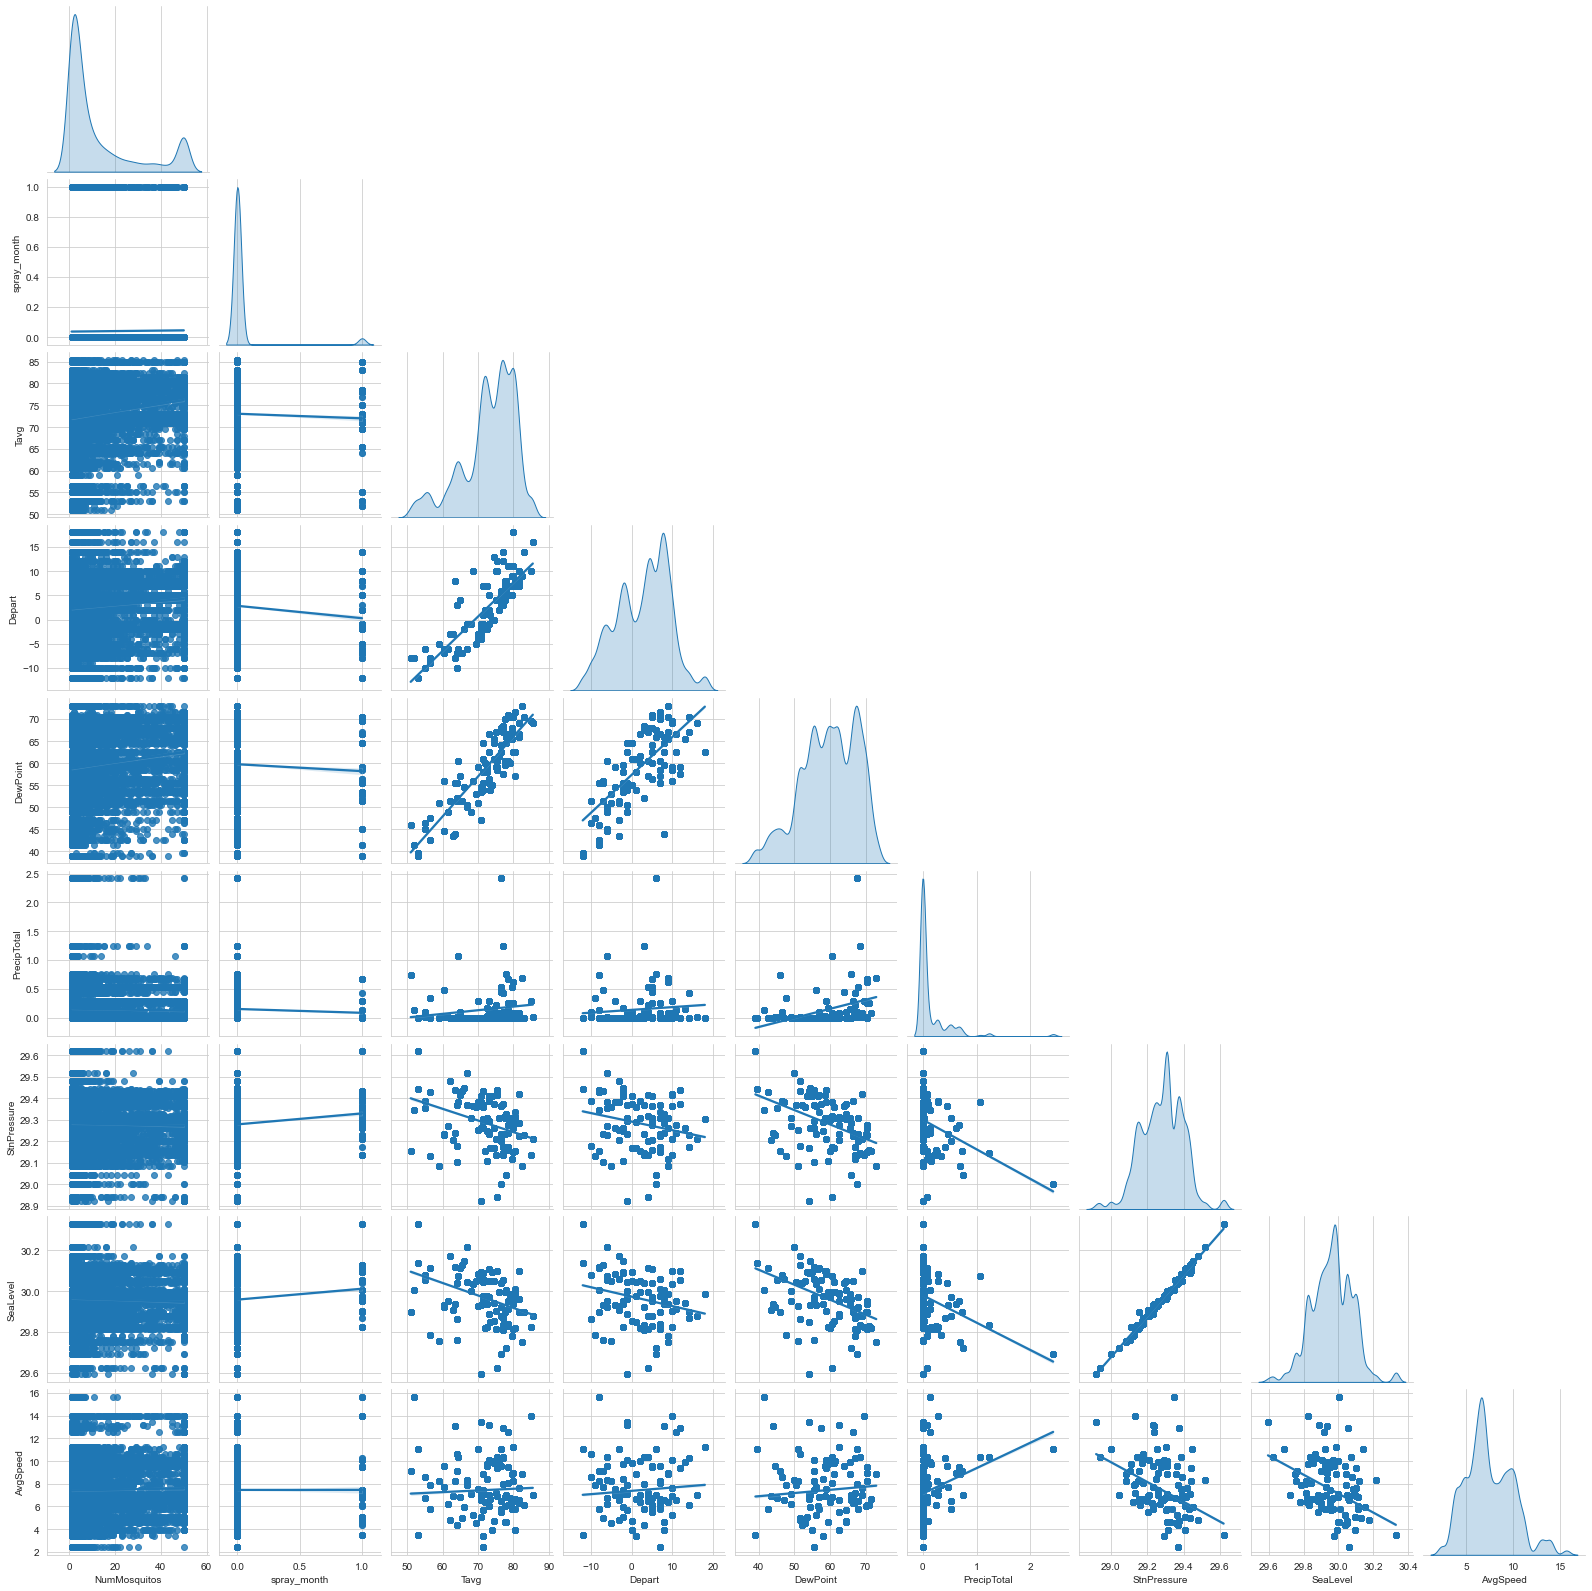

<Figure size 2160x2160 with 0 Axes>

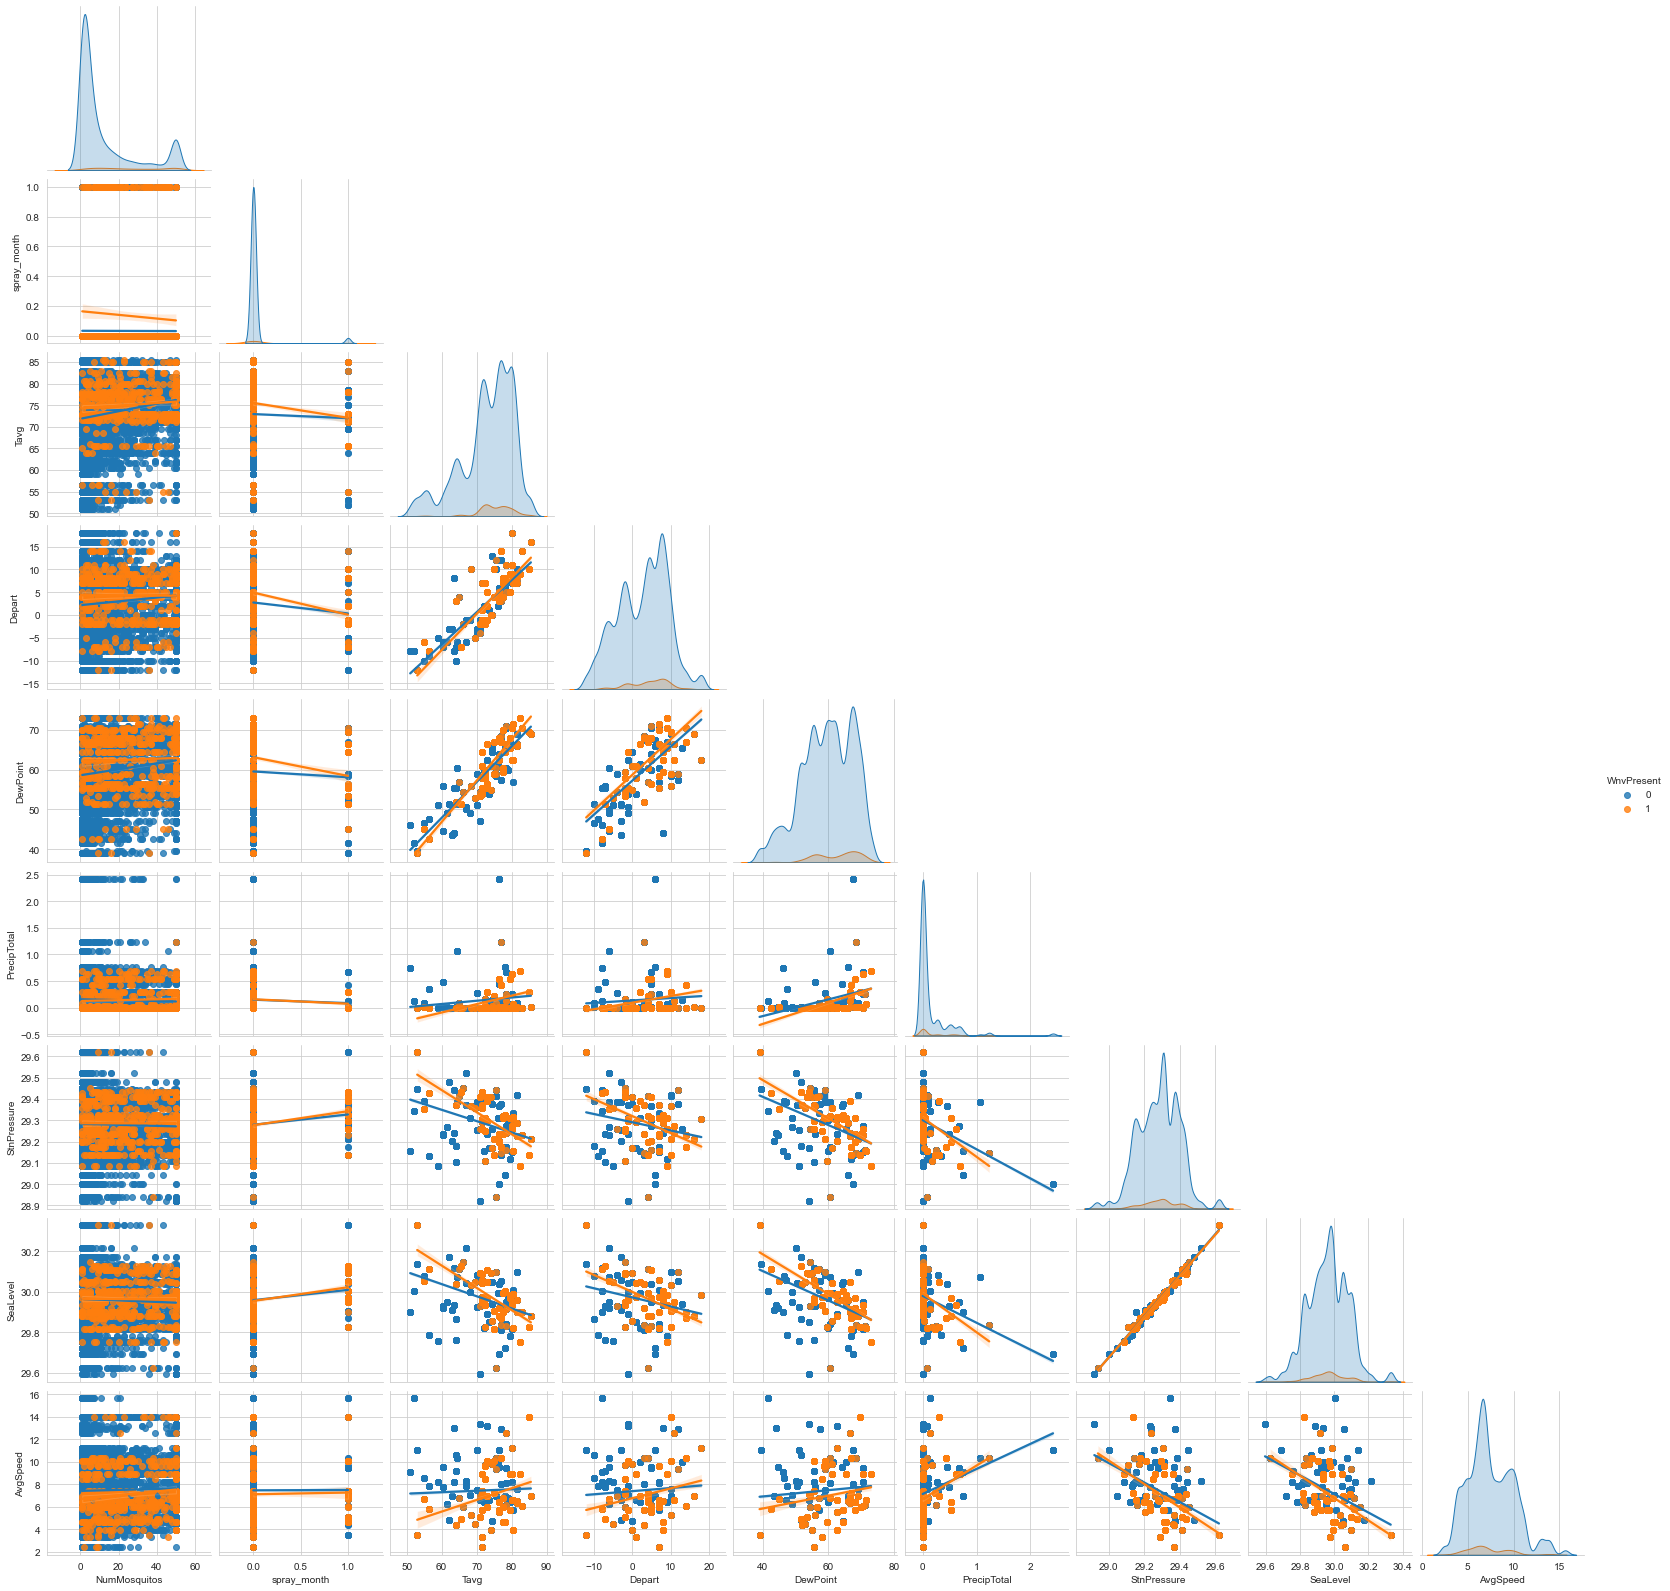

In [47]:
p_plot(df_num, vars1,'./plots/pairplot1.png',h=False)
p_plot(df_num, vars1,'./plots/pairplot1_with_hue.png',h=True)

from the first pairplots it's clear that StnPressure and SeaLevel are highly correlated and likely represent a similar concept. Whichever variable has a better information value I will stick with, and the other I'll drop.

We also see strong relationships to Tavg, indicating temperature is a mediating factor in a lot of weather.

<Figure size 2160x2160 with 0 Axes>

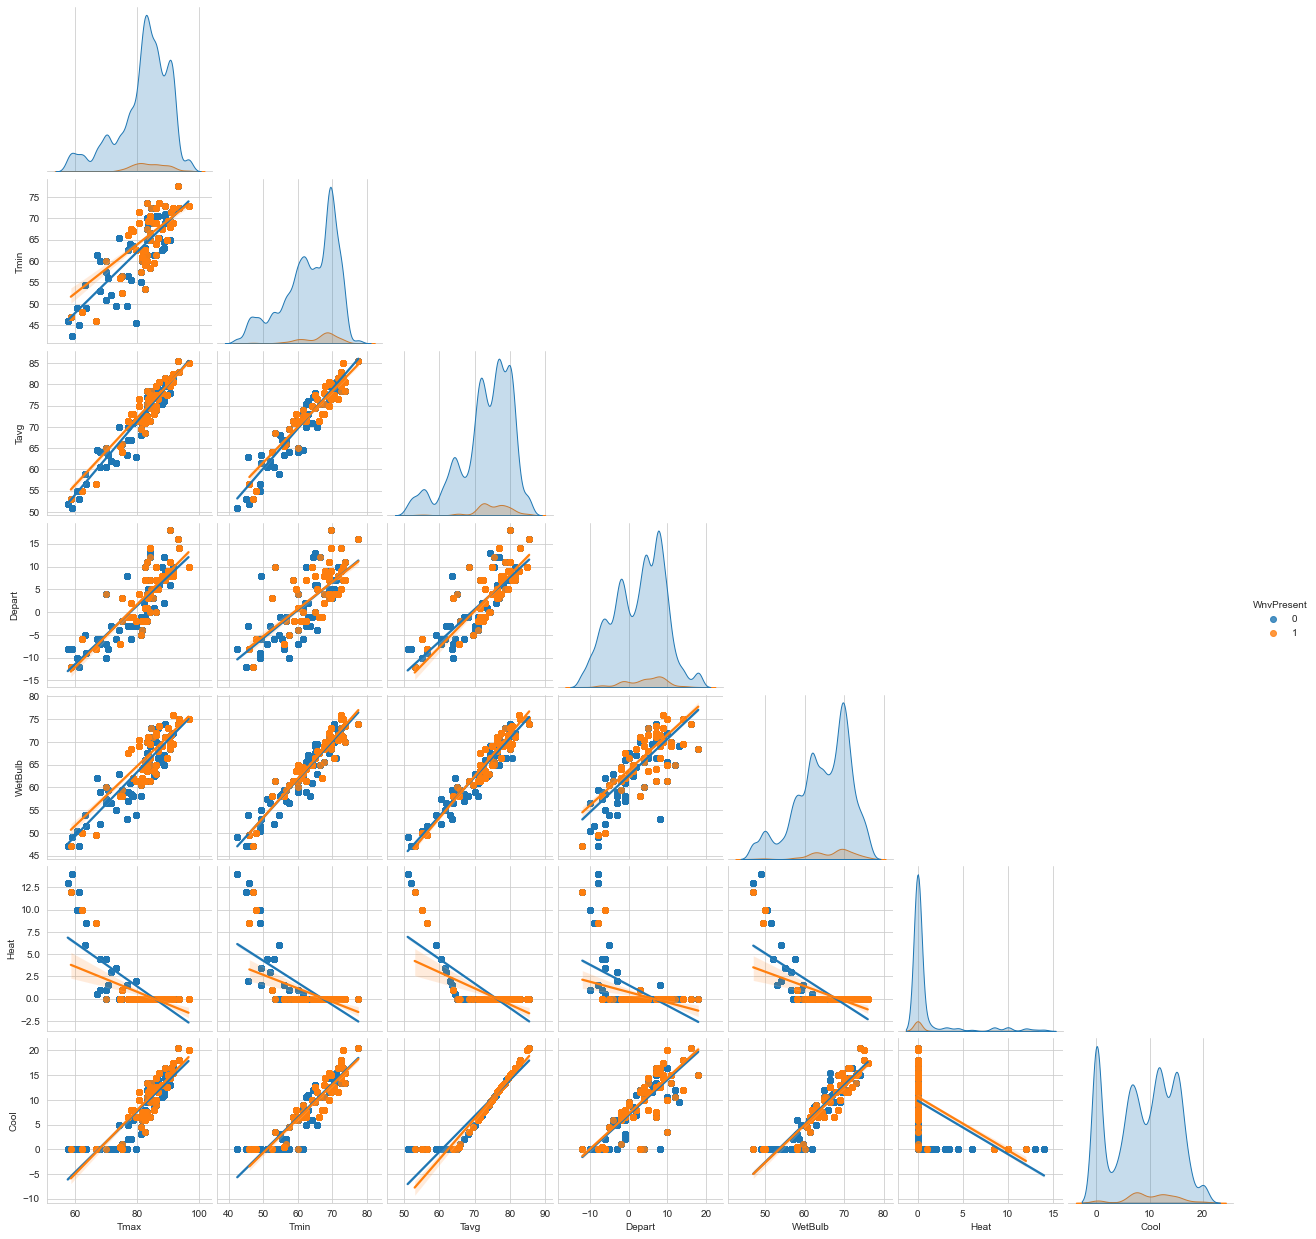

<Figure size 2160x2160 with 0 Axes>

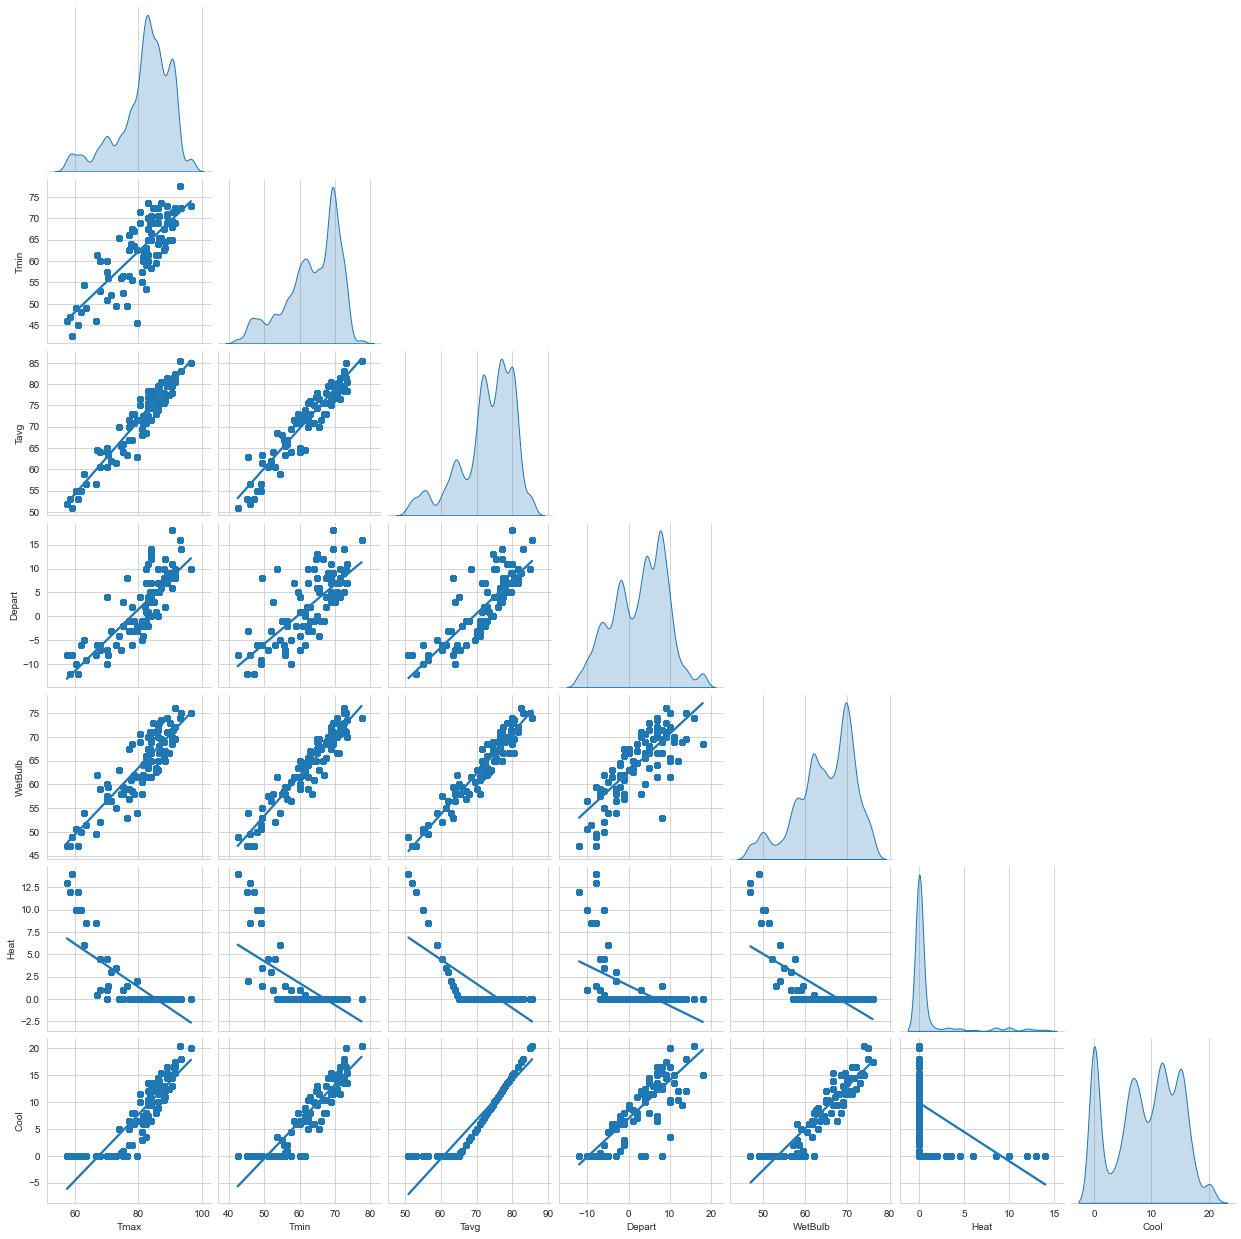

In [48]:
vars2= ['Tmax','Tmin','Tavg','Depart','WetBulb','Heat','Cool']
p_plot(df_num,vars2,'./plots/temp_pair_plots_hued.png',h=True)
p_plot(df_num,vars2,'./plots/temp_pair_plots.png')

We see above that temperature is represented in many different ways. There are strong relationships between all of the variables. 

### 2.3.2 Species 
<a id='species'></a>

WNV can only be carrier by two mosquito species, pipens or restauns. Unfortunately the data is highly class biased, and the vast majority of mosquitos are of the two species that can carry WNV. I create a boolean variable with 1 as a positive indication for species and 0 otherwise.

In [49]:
df.groupby('Species').describe().T

Species             CULEX ERRATICUS  CULEX PIPIENS  CULEX PIPIENS/RESTUANS  \
Latitude     count         1.000000    2699.000000             4752.000000   
             mean         41.974689      41.813402               41.848832   
             std                NaN       0.115259                0.110800   
             min          41.974689      41.644612               41.644612   
             25%          41.974689      41.704572               41.750498   
             50%          41.974689      41.793818               41.868077   
             75%          41.974689      41.923738               41.954690   
             max          41.974689      42.017430               42.017430   
Longitude    count         1.000000    2699.000000             4752.000000   
             mean        -87.890615     -87.680481              -87.705241   
             std                NaN       0.095400                0.095853   
             min         -87.890615     -87.930995              -87.930995   
             25%         -87.890615     -87.745602              -87.763416   
             50%         -87.890615     -87.674677              -87.700117   
             75%         -87.890615     -87.599862              -87.642984   
             max         -87.890615     -87.531635              -87.531635   
NumMosquitos count         1.000000    2699.000000             4752.000000   
             mean          7.000000      16.550945               13.945286   
             std                NaN      19.040433               15.995301   
             min           7.000000       1.000000                1.000000   
             25%           7.000000       2.000000                2.000000   
             50%           7.000000       6.000000                6.000000   
             75%           7.000000      31.000000               20.000000   
             max           7.000000      50.000000               50.000000   
WnvPresent   count         1.000000    2699.000000             4752.000000   
             mean          0.000000       0.088922                0.055135   
             std                NaN       0.284684                0.228267   
             min           0.000000       0.000000                0.000000   
             25%           0.000000       0.000000                0.000000   
             50%           0.000000       0.000000                0.000000   
             75%           0.000000       0.000000                0.000000   
             max           0.000000       1.000000                1.000000   
spray_year   count         1.000000    2699.000000             4752.000000   
             mean          0.000000       0.082253                0.118687   
             std                NaN       0.274800                0.323454   
             min           0.000000       0.000000                0.000000   
             25%           0.000000       0.000000                0.000000   
             50%           0.000000       0.000000                0.000000   
             75%           0.000000       0.000000                0.000000   
             max           0.000000       1.000000                1.000000   
spray_month  count         1.000000    2699.000000             4752.000000   
             mean          0.000000       0.034828                0.039352   
             std                NaN       0.183377                0.194451   
             min           0.000000       0.000000                0.000000   
             25%           0.000000       0.000000                0.000000   
             50%           0.000000       0.000000                0.000000   
             75%           0.000000       0.000000                0.000000   
             max           0.000000       1.000000                1.000000   
spray_day    count         1.000000    2699.000000             4752.000000   
             mean          0.000000       0.005558                0.005892   
             std      

<AxesSubplot:xlabel='WnvPresent', ylabel='Species'>

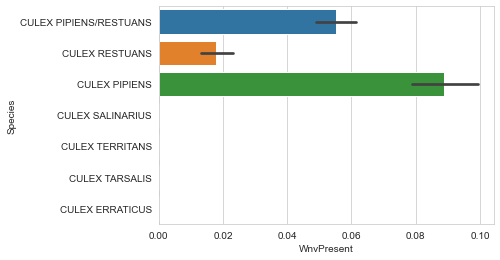

In [50]:
sns.barplot(data=df,y='Species',x='WnvPresent')


<AxesSubplot:xlabel='Species'>

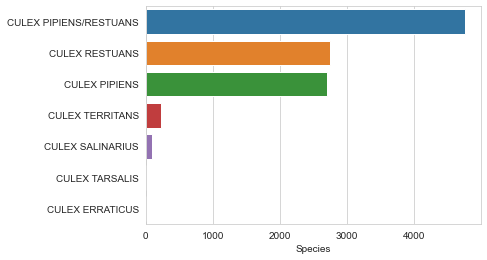

In [51]:
sns.barplot(y=df.Species.value_counts().index, x=df.Species.value_counts())

In [52]:
df['cul_or_pip'] = [1 if s in ['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS'] else 0 for s in df.Species]


### 2.3.3 WNV comparisons
<a id='grouped'></a>

For the numerical data, I create violin plots to looks at any differences in the distributions for WNV present or not.

<AxesSubplot:xlabel='WnvPresent', ylabel='Tavg'>

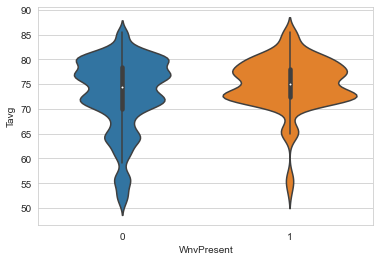

In [53]:
sns.violinplot(data=df_avg,x='WnvPresent',y='Tavg')

In [54]:
df_avg.WnvPresent.corr(df_avg.Tavg)

0.0642559817674728

It appears as though temperatures trend higher when WNV is present. The relationship is not strong and has a low correlation.

<AxesSubplot:xlabel='WnvPresent', ylabel='PrecipTotal'>

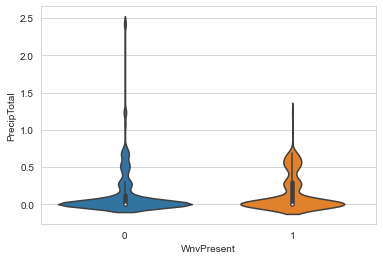

In [55]:
sns.violinplot(data=df_avg,x='WnvPresent',y='PrecipTotal')

Precipitation is somewhat unclear, despite the association with mosquitos.

In [56]:
#rolling total pepceiption on a few different time scales. 
w_avg['three_day_rain'] = w_avg['PrecipTotal'].rolling(3, min_periods=1).sum()
w_avg['week_rain'] = w_avg['PrecipTotal'].rolling(7, min_periods=1).sum()
w_avg['two_week_rain'] = w_avg['PrecipTotal'].rolling(14, min_periods=1).sum()
w_avg['month_rain'] = w_avg['PrecipTotal'].rolling(28, min_periods=1).sum()



In [57]:
df_avg = df.merge(w_avg,on='Date')


<AxesSubplot:xlabel='WnvPresent', ylabel='three_day_rain'>

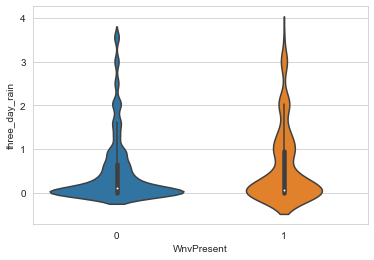

In [58]:
sns.violinplot(data=df_avg,x='WnvPresent',y='three_day_rain')

<AxesSubplot:xlabel='WnvPresent', ylabel='week_rain'>

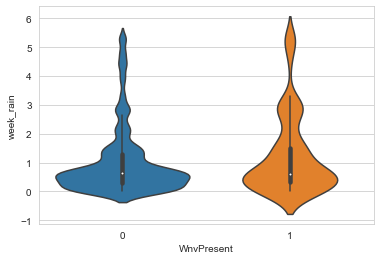

In [59]:
sns.violinplot(data=df_avg,x='WnvPresent',y='week_rain')

<AxesSubplot:xlabel='WnvPresent', ylabel='two_week_rain'>

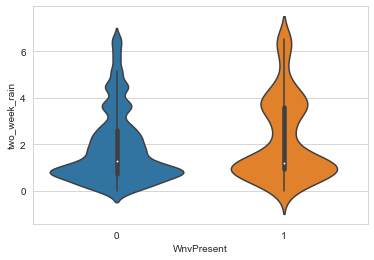

In [60]:
sns.violinplot(data=df_avg,x='WnvPresent',y='two_week_rain')

<AxesSubplot:xlabel='WnvPresent', ylabel='month_rain'>

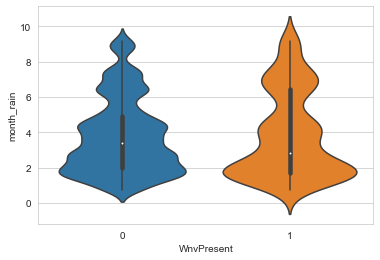

In [61]:
sns.violinplot(data=df_avg,x='WnvPresent',y='month_rain')

<AxesSubplot:>

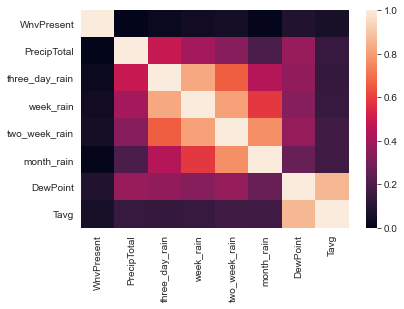

In [62]:
subset = df_avg[['WnvPresent','PrecipTotal','three_day_rain','week_rain','two_week_rain',
                'month_rain','DewPoint','Tavg']]
sns.heatmap(subset.corr())

In [63]:
corr = df_avg.corr()
corr['WnvPresent']



Latitude          0.028697
Longitude        -0.060345
NumMosquitos      0.196820
WnvPresent        1.000000
spray_year        0.078184
spray_month       0.115555
spray_day         0.050164
cul_or_pip        0.041362
Tmax              0.048244
Tmin              0.074048
Tavg              0.064256
Depart            0.055436
DewPoint          0.085883
WetBulb           0.079363
Heat             -0.054740
Cool              0.058101
Sunrise           0.111944
Sunset           -0.068844
PrecipTotal      -0.000577
StnPressure       0.010128
SeaLevel          0.006480
ResultSpeed      -0.046298
ResultDir         0.000175
AvgSpeed         -0.029416
sunrise_diff      0.079836
sunset_diff      -0.107039
dev_65            0.064256
BR                0.044808
HZ                0.016236
RA                0.009714
TSRA              0.043148
TS                0.047925
DZ               -0.019889
FG                0.098846
three_day_rain    0.029163
week_rain         0.045091
two_week_rain     0.052931
m

Aside from NumMosquitos, there are not many features that are highly correlated to WNV

<AxesSubplot:xlabel='WnvPresent', ylabel='spray_month'>

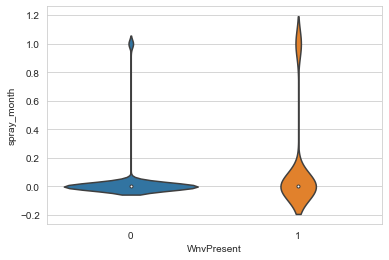

In [64]:
sns.violinplot(data=df_avg,x='WnvPresent',y='spray_month')

<AxesSubplot:xlabel='WnvPresent', ylabel='Sunrise'>

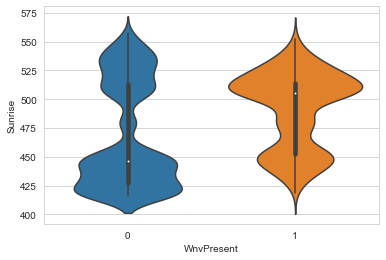

In [65]:
sns.violinplot(data=df_avg,x='WnvPresent',y='Sunrise')

<AxesSubplot:xlabel='WnvPresent', ylabel='SeaLevel'>

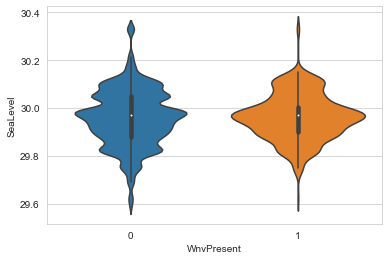

In [66]:
sns.violinplot(data=df_avg,x='WnvPresent',y='SeaLevel')

<AxesSubplot:xlabel='WnvPresent', ylabel='AvgSpeed'>

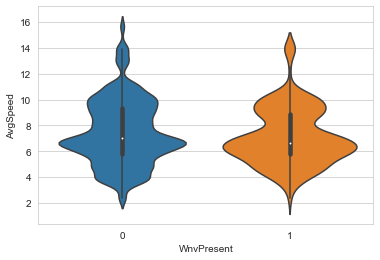

In [67]:
sns.violinplot(data=df_avg,x='WnvPresent',y='AvgSpeed')

<AxesSubplot:xlabel='WnvPresent', ylabel='DewPoint'>

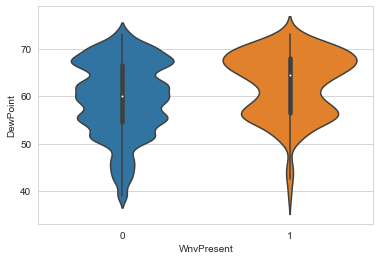

In [68]:
sns.violinplot(data=df_avg,x='WnvPresent',y='DewPoint')

In [69]:
df_avg['T_spread'] = df_avg.Tmax - df_avg.Tmin
df_avg['longer_days'] = [1 if r[0] - r[1] > 0 else 0 for i,r in df_avg[['sunset_diff','sunrise_diff']].iterrows()]

In [70]:
df_avg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10506 entries, 0 to 10505
Data columns (total 43 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            10506 non-null  datetime64[ns]
 1   Species         10506 non-null  object        
 2   Trap            10506 non-null  object        
 3   Latitude        10506 non-null  float64       
 4   Longitude       10506 non-null  float64       
 5   NumMosquitos    10506 non-null  int64         
 6   WnvPresent      10506 non-null  int64         
 7   spray_year      10506 non-null  int64         
 8   spray_month     10506 non-null  int64         
 9   spray_day       10506 non-null  int64         
 10  cul_or_pip      10506 non-null  int64         
 11  Tmax            10506 non-null  float64       
 12  Tmin            10506 non-null  float64       
 13  Tavg            10506 non-null  float64       
 14  Depart          10506 non-null  float64       
 15  De

### 2.3.4 Lagged Variables
<a id='lagged'></a>

Here I will explore how correlation changes based on the lag in the variable. For each variable, I will save the index (lag or span) that produced the best correlation

In [71]:
#lagged weather
def lagged(df,n):
    return df.rolling(n, min_periods=1).mean().dropna()

def exp_lag(df,n):
    return df.ewm(span=n,min_periods=1).mean().dropna()

df_to_lag = df_avg.iloc[:,11:19].join(df_avg.iloc[:,21:27]).join(df_avg.iloc[:,29:36]).join(df_avg.iloc[:,40:]).join(df_avg.iloc[:,9])



In [72]:
we1 = {s:exp_lag(df_to_lag,s) for s in np.arange(2,8)}
wl1 = {s:lagged(df_to_lag,s) for s in np.arange(2,8)}
we2 = {s:exp_lag(df_to_lag,s) for s in np.arange(8,18,2)}
wl2 = {s:lagged(df_to_lag,s) for s in np.arange(8,18,2)}
we3 = {s:exp_lag(df_to_lag,s) for s in np.arange(18,60,4)}
wl3 = {s:lagged(df_to_lag,s) for s in np.arange(18,60,4)}


In [73]:
df_list = [we1,wl1,we2,wl2,we3,wl3]


def incorporate(df_original,d_list):
    count = 0
    for df_dict in d_list:
        count+=1 
        for lag, df in df_dict.items():
            
            if count % 2 == 0:
                t = 'exp'
            else:
                t = 'lag'  
                

            new_col = []

            for col in df.columns:
                new_col.append(str(col)+' ' + str(lag) + ' ' + t)
            df.columns = new_col
            
            df_original = df_original.join(df)
            
    
    return df_original
    
    
df_all = incorporate(df_avg,df_list)

In [74]:
df_all.columns[1000:1020]

Index(['Cool 38 exp', 'PrecipTotal 38 exp', 'StnPressure 38 exp',
       'SeaLevel 38 exp', 'ResultSpeed 38 exp', 'ResultDir 38 exp',
       'AvgSpeed 38 exp', 'dev_65 38 exp', 'BR 38 exp', 'HZ 38 exp',
       'RA 38 exp', 'TSRA 38 exp', 'TS 38 exp', 'DZ 38 exp',
       'month_rain 38 exp', 'T_spread 38 exp', 'longer_days 38 exp',
       'spray_day 38 exp', 'Tmax 42 exp', 'Tmin 42 exp'],
      dtype='object')

### 2.3.5 Information Value
<a id='inf_val'></a>

In [75]:
pd.options.mode.use_inf_as_na = True

max_bin = 20
force_bin = 2

def mono_bin(Y, X, n = max_bin):
    
    np.seterr(divide='ignore', invalid='ignore')
    pd.options.mode.use_inf_as_na = True

    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isna()]
    notmiss = df1[['X','Y']][~df1.X.isna()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n,duplicates='drop')})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        bucket = pd.cut(notmiss.X, np.unique(bins),include_lowest=True)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": bucket}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = np.divide(d3.EVENT,d3.COUNT)
    d3["NON_EVENT_RATE"] = np.divide(d3.NONEVENT,d3.COUNT)
    d3["DIST_EVENT"] = np.divide(d3.EVENT,d3.sum().EVENT)
    d3["DIST_NON_EVENT"] = np.divide(d3.NONEVENT,d3.sum().NONEVENT)
    d3["WOE"] = np.log(np.divide(d3.DIST_EVENT,d3.DIST_NON_EVENT))
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*d3.WOE
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    
    d3["EVENT_RATE"] = np.divide(d3.EVENT,d3.COUNT)
    d3["NON_EVENT_RATE"] = np.divide(d3.NONEVENT,d3.COUNT)
    d3["DIST_EVENT"] = np.divide(d3.EVENT,d3.sum().EVENT)
    d3["DIST_NON_EVENT"] = np.divide(d3.NONEVENT,d3.sum().NONEVENT)
    d3["WOE"] = np.log(np.divide(d3.DIST_EVENT,d3.DIST_NON_EVENT))
    
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        #print(i)
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(pd.Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [76]:
df_ivs, IV = data_vars(df_all.drop('WnvPresent',axis=1),df_all['WnvPresent'])
to_drop = IV[(IV.IV > 0.8) | (IV.IV < 0.01)]
df_iv = df_all.drop(to_drop.VAR_NAME, axis=1)

/Users/jon/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [77]:
df_iv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10506 entries, 0 to 10505
Columns: 474 entries, Species to month_rain 58 exp
dtypes: float64(468), int64(4), object(2)
memory usage: 38.4+ MB


In [78]:
IV = IV.set_index('VAR_NAME')

In [79]:
df_avg.columns

Index(['Date', 'Species', 'Trap', 'Latitude', 'Longitude', 'NumMosquitos',
       'WnvPresent', 'spray_year', 'spray_month', 'spray_day', 'cul_or_pip',
       'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool',
       'Sunrise', 'Sunset', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed', 'sunrise_diff', 'sunset_diff',
       'dev_65', 'BR', 'HZ', 'RA', 'TSRA', 'TS', 'DZ', 'FG', 'three_day_rain',
       'week_rain', 'two_week_rain', 'month_rain', 'T_spread', 'longer_days'],
      dtype='object')

In [80]:
features = []
wnv = df_avg.WnvPresent
df_a = df_avg.drop(['WnvPresent','three_day_rain','two_week_rain','month_rain','week_rain','spray_month'
                    ,'spray_year','sunset_diff','Cool','Heat','longer_days', 'Species','Trap'],axis=1)
for column in df_a.columns:
    cols = []
    for col in df_iv.columns:
        if column in col:
            cols.append(col)
    if len(cols)>= 2:
        iv=0
        max_iv = 0
        c_to_save = ''
        for c in cols:      
            try:
                iv = IV.loc[c]
            except Exception as e:
                continue
            
            if iv[0] >= max_iv:
                max_iv = iv[0]
                c_to_save = c     
        features.append(c_to_save)
    else:
        for c in cols:
            features.append(c)


In [81]:
features

['spray_day 4 lag',
 'Tmin 46 exp',
 'Depart 14 exp',
 'DewPoint 6 exp',
 'WetBulb 12 exp',
 'Sunrise',
 'Sunset',
 'PrecipTotal 2 exp',
 'ResultSpeed 58 lag',
 'ResultDir 6 exp',
 'AvgSpeed 58 lag',
 'sunrise_diff',
 'dev_65 58 lag',
 'BR 50 exp',
 'HZ 10 exp',
 'TS 38 exp',
 'FG']

In [82]:
df_X = df_iv[features]

### 2.3.6 Variance inflation factor 
<a id='var_in'></a>

In [83]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def iterate_vif(df, vif_threshold=6, max_vif=11):
  count = 0
  while max_vif > vif_threshold:
    count += 1
    print("Iteration # "+str(count))
    vif = pd.DataFrame()
    vif["VIFactor"] = [variance_inflation_factor(df.to_numpy(), i) for i in range(df.shape[1])]
    vif["features"] = df.columns
    
    if np.round(vif['VIFactor'].max(),1) > vif_threshold:
      print('Removing %s with VIF of %f' % (vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], np.round(vif['VIFactor'].max(),1)))
      df = df.drop(vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], axis=1)
      max_vif = np.round(vif['VIFactor'].max(),1)
    else:
        print('Complete')
        return df, np.round(vif.sort_values('VIFactor'),1)

In [84]:
X = df_X
y = wnv

In [85]:
X2, vif = iterate_vif(X._get_numeric_data())

Iteration # 1
Removing WetBulb 12 exp with VIF of 7132.600000
Iteration # 2
Removing Tmin 46 exp with VIF of 1159.100000
Iteration # 3
Removing DewPoint 6 exp with VIF of 359.600000
Iteration # 4
Removing Sunset with VIF of 162.000000
Iteration # 5
Removing AvgSpeed 58 lag with VIF of 91.100000
Iteration # 6
Removing Sunrise with VIF of 11.200000
Iteration # 7
Complete


In [86]:
X2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10506 entries, 0 to 10505
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   spray_day 4 lag     10506 non-null  float64
 1   Depart 14 exp       10506 non-null  float64
 2   PrecipTotal 2 exp   10506 non-null  float64
 3   ResultSpeed 58 lag  10506 non-null  float64
 4   ResultDir 6 exp     10506 non-null  float64
 5   sunrise_diff        10506 non-null  float64
 6   dev_65 58 lag       10506 non-null  float64
 7   BR 50 exp           10506 non-null  float64
 8   HZ 10 exp           10506 non-null  float64
 9   TS 38 exp           10506 non-null  float64
 10  FG                  10506 non-null  float64
dtypes: float64(11)
memory usage: 1.3 MB


In [87]:
vif

,VIFactor,features
0,1.1,spray_day 4 lag
5,1.3,sunrise_diff
10,1.4,FG
2,1.9,PrecipTotal 2 exp
8,2.0,HZ 10 exp
9,2.5,TS 38 exp
7,2.6,BR 50 exp
1,3.1,Depart 14 exp
4,4.7,ResultDir 6 exp
3,4.9,ResultSpeed 58 lag


In [88]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

X2.to_pickle('./data/X2.pkl')
y.to_pickle('./data/y.pkl')

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X2,y, test_size = 0.2, random_state = 42)

In [90]:
rf = RandomForestClassifier()

params = {'n_estimators': np.arange(750,2000,50),'max_depth': np.arange(3,8)}

rf_rand = RandomizedSearchCV(rf,param_distributions=params,cv=5, n_jobs=-1, scoring = 'roc_auc',n_iter=10,
                            random_state = 42, verbose=10)

In [91]:
rf_rand.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:  1.0min remaining:   13.3s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:  1.1min remaining:    4.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.2min finished


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': array([3, 4, 5, 6, 7]),
                                        'n_estimators': array([ 750,  800,  850,  900,  950, 1000, 1050, 1100, 1150, 1200, 1250,
       1300, 1350, 1400, 1450, 1500, 1550, 1600, 1650, 1700, 1750, 1800,
       1850, 1900, 1950])},
                   random_state=42, scoring='roc_auc', verbose=10)

In [92]:
rf_rand.best_score_

0.7947791851630506

In [93]:
from sklearn.metrics import roc_auc_score

y_pred = rf_rand.best_estimator_.predict_proba(X_test)

roc_auc_score(y_test,y_pred[:,1])


0.8183438298649142

<AxesSubplot:xlabel='importance', ylabel='feature'>

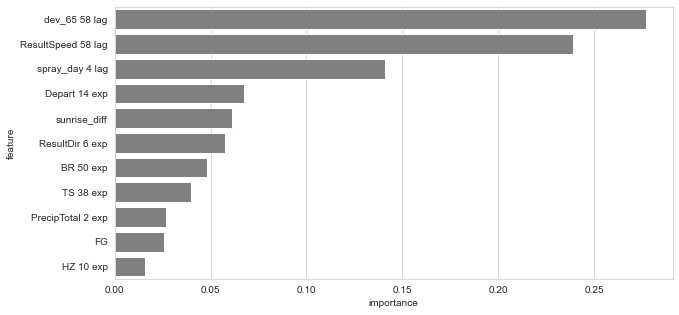

In [94]:
r = rf_rand.best_estimator_
imp = r.feature_importances_

ax = plt.figure(figsize=(10,5))

i = pd.DataFrame({'feature':X_test.columns,'importance':imp}).sort_values('importance',ascending=False)

sns.barplot(data=i,y='feature',x='importance',orient='h',color='gray')

In [95]:
from sklearn.metrics import roc_curve

def roc_plot(e,x,y):
    """e is estimator, x is data and y is true value"""

    #predicting from model
    y_pred = e.predict_proba(x)[:,1]

    #finding curve
    fpr, tpr, t = roc_curve(y, y_pred)
    sns.lineplot(x=fpr,y=tpr)
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.title('Compute Receiver Operating Characteristic Curve')
    return pd.DataFrame({'fpr':fpr,'tpr':tpr,'threshold':t})

from sklearn.metrics import roc_auc_score


def test_comp(e):
    #predicting probability from test set
    y_pred = e.predict_proba(X_test)[:,1]
    
    
    r = np.round(roc_auc_score(y_test,y_pred),3)
    
    print('Evaluating the classifier on the test set, area under the roc curve is: ' +  
           '{}'.format(r))

test_comp(rf_rand.best_estimator_)



Evaluating the classifier on the test set, area under the roc curve is: 0.818


In [96]:
test_comp(rf_rand.best_estimator_)

Evaluating the classifier on the test set, area under the roc curve is: 0.818


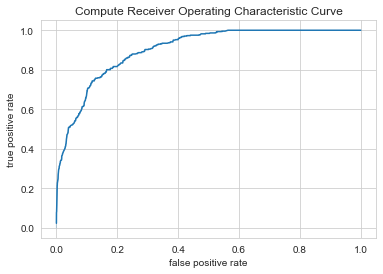

In [97]:
est = rf_rand.best_estimator_
c = roc_plot(est, X_train, y_train)